# Compare Modtran/libRadTran Magnitudes

Study wide range in pwv

- author : Sylvie Dagoret
- affiliation : LAL/IN2P3/CNRS
- creation date : July 10th 2018
- update : July 12th 2018



In [1]:
import pandas as pd
import numpy as np
import os,sys
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from astropy.io import fits
%matplotlib inline
from scipy.interpolate import interp1d

In [2]:
from astropy.io import fits

In [3]:
from lsst.sims.photUtils import SignalToNoise
from lsst.sims.photUtils import PhotometricParameters
from lsst.sims.photUtils import Bandpass,Sed

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

In [6]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (14, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [7]:
PATH_LIBRADTRAN='./librandtran'
PATH_MODTRAN='./modtran'
PATH_MYLSSTSIMS='./lsst_sims'

In [8]:
sys.path.append(PATH_LIBRADTRAN)
sys.path.append(PATH_MODTRAN)
sys.path.append(PATH_MYLSSTSIMS)

In [9]:
import libReadModtran as mt
import libsimulateTranspLSSTScattAbsAer3 as rt

In [10]:
from MyTelescope import *
from MyThroughputs import *

In [11]:
def plot_sedimg(data,index_spec):
    plt.figure(figsize=(15,10))   
    img=plt.imshow(data[1:,index_spec:],origin='lower',cmap='jet')
    plt.colorbar(img)
    plt.grid(True)
    plt.title('sed grid')
    plt.xlabel('bin number of wavelengths')
    plt.ylabel('sed number')
    plt.show()

In [12]:
def plot_allsed(data,index_spec):
    plt.figure()   
    
    for idx in np.arange(data.shape[0]-1):
      
        plt.semilogy(data[0,index_spec:],data[1+idx,index_spec:],'-')
    plt.grid(True)
    plt.title('sed')
    plt.xlabel('wavelength (A)')
    plt.ylabel('sed (flam)')
    plt.show()

# Config

In [13]:
#------------------------------------------------------------------------
# Definition of data format for the atmospheric grid
#-----------------------------------------------------------------------------
WLMIN=250.  # Minimum wavelength : PySynPhot works with Angstrom
WLMAX=1151. # Minimum wavelength : PySynPhot works with Angstrom
WL=np.arange(WLMIN,WLMAX,1) # Array of wavelength in Angstrom
NBWL=len(WL)


In [14]:
## Config LSST

In [15]:
all_filternum = {'u':1, 'g':2, 'r':3, 'i':4, 'z':5, 'y':6}

In [16]:
LSST_SkyBrightness=np.array([22.03,21.68,21.02,19.7,17.83,17.21])

In [17]:
LSST_GeomSeeing=np.array([1.1,1.02,0.95,0.92,0.88,0.94])

# Configuration of input SED

In [18]:
sed_file="regenerated_sedgrid_pickle_uvk.fits"

In [19]:
sed_hdu = fits.open(sed_file)

In [20]:
theheader=sed_hdu[0].header
theheader

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 8515                                                  
NAXIS2  =                12963                                                  
NBSED   =                12962                                                  
NBWLBIN =                 8510                                                  
WLMIN   =               3000.0                                                  
WLMAX   =              11510.0                                                  
WLBINWDT=                  1.0                                                  
SEDUNIT = 'FLAM    '                                                            
SEDMODEL= 'pickle_uvk'                                                          
IDX_NUM =                   

In [21]:
sidx_num=theheader['IDX_NUM']
sidx_val=theheader['IDX_VAL']
sidx_sed=theheader['IDX_SED']
sidx_data=theheader['IDX_DATA']
sidx_spec=theheader['IDX_SPEC']

In [22]:
sed_data=sed_hdu[0].data

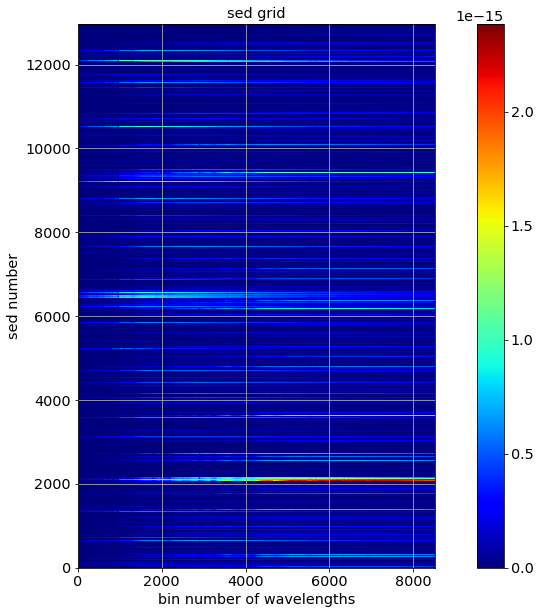

In [23]:
plot_sedimg(sed_data,sidx_spec)

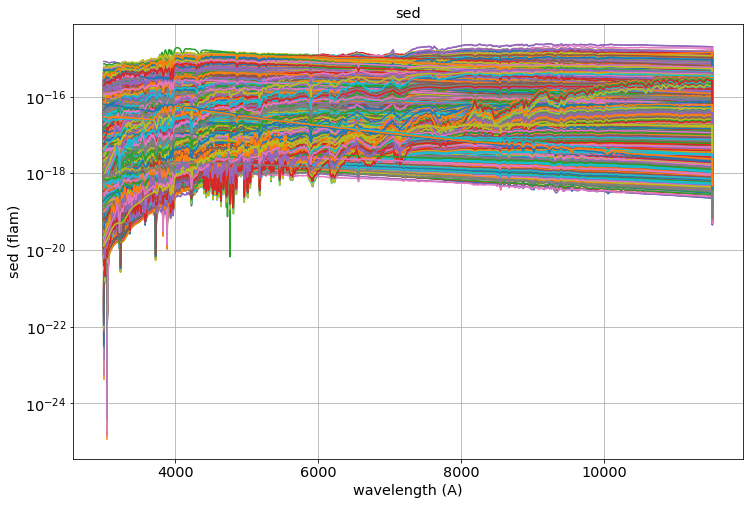

In [24]:
plot_allsed(sed_data,sidx_spec)

In [25]:
NBSED_MAX=sed_data.shape[0]-1

In [26]:
NBSED_MAX

12962

## Config for Modtran

In [27]:
path_modtrandata='modtrandata/Jul6th2018'

In [28]:
def GetModtranFilenames():
    files_data = [f for f in listdir(path_modtrandata) if isfile(join(path_modtrandata, f))]
    files_data.sort()
    
    # select reduced files
    files_selected=[]
    for file in files_data:
        if file.find("_reduced")==-1:
            print("reject ",file)
        else:
            files_selected.append(file)
            
    files_selected.sort()
    return files_selected


In [29]:
def GetAirmassFromModtranFilename(filename):
    splitted_filename=filename.split('.')
    tagname=splitted_filename[1]
    airmass_str=tagname.split('_')[0]
    am=float(airmass_str)/10.
    return am
    

In [30]:
files_modtran=GetModtranFilenames()

reject  Pachon_MODTRAN.10.7sc
reject  Pachon_MODTRAN.11.7sc
reject  Pachon_MODTRAN.12.7sc
reject  Pachon_MODTRAN.13.7sc
reject  Pachon_MODTRAN.14.7sc
reject  Pachon_MODTRAN.15.txt
reject  Pachon_MODTRAN.16.7sc
reject  Pachon_MODTRAN.17.7sc
reject  Pachon_MODTRAN.18.7sc
reject  Pachon_MODTRAN.19.7sc
reject  Pachon_MODTRAN.20.7sc
reject  Pachon_MODTRAN.21.7sc
reject  Pachon_MODTRAN.22.7sc
reject  Pachon_MODTRAN.23.7sc
reject  Pachon_MODTRAN.25.7sc
reject  Pachon_MODTRAN.7sc


In [31]:
NBMTFILES=len(files_modtran)-1

### Get all all available Modtran Airmasss

In [32]:
all_airmasses=[GetAirmassFromModtranFilename(files_modtran[idx]) for idx in np.arange(NBMTFILES) ]

In [33]:
all_airmasses

[1.0, 1.1, 1.2, 1.3, 1.4, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.5]

### Read all Modtran Data

In [34]:
all_mtdata=[]
for file in files_modtran:
    fullfilename=os.path.join(path_modtrandata,file)
    read_modtrandata=mt.loadtape7(fullfilename, colspec = ['WAVELENGTH_NM','COMBIN_TRANS'])
    all_mtdata.append(read_modtrandata)

### View all Modtran Data

In [35]:
jet = cm = plt.get_cmap('jet')
cNorm  = colors.Normalize(vmin=0, vmax=NBMTFILES)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

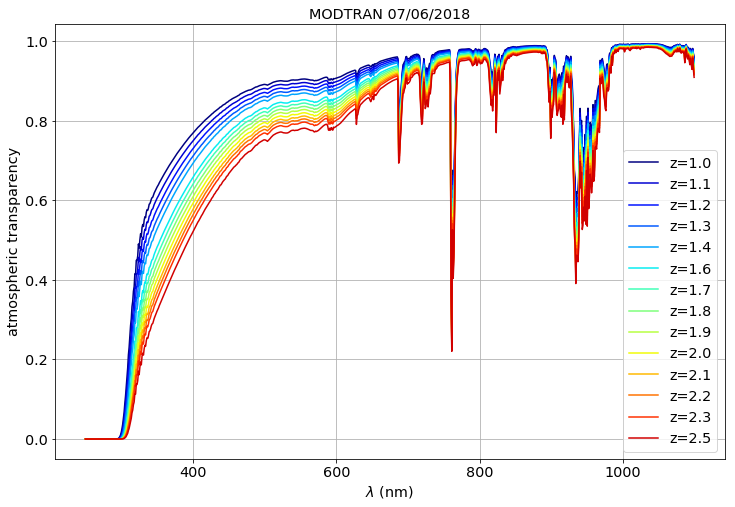

In [36]:
for idx in np.arange(NBMTFILES):    
    colorVal = scalarMap.to_rgba(idx)
    thelabel="z={:2.1f}".format(all_airmasses[idx])
    plt.plot(all_mtdata[idx][:,0],all_mtdata[idx][:,1],color=colorVal,label=thelabel)
plt.grid(True)
plt.title("MODTRAN 07/06/2018")
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("atmospheric transparency")
plt.legend(loc='best')

In [37]:
all_airmasses

[1.0, 1.1, 1.2, 1.3, 1.4, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.5]

# Select One Airmass and One Filter where to do the Comparison

In [38]:
idx_am_sel=2

In [39]:
am=all_airmasses[idx_am_sel]

In [40]:
mtdata_sel=all_mtdata[idx_am_sel]

Must extend Motran transmission up from 250 nm to 1151 nm

In [41]:
wl0=mtdata_sel[:,0]
tr0=mtdata_sel[:,1]

In [42]:
wl=np.copy(WL)
tr=np.ones(NBWL)

wl[:len(wl0)]=wl0[:]
tr[:len(tr0)]=tr0[:]


In [43]:
tel_mt=Telescope()

**** Throughputs.__init__****
System loaded from /sps/lsst/software/lsst_sims/sims_2_7_0/stack/miniconda3-4.3.21-10a4fa6/Linux64/throughputs/2017.01.31-6-g29ce4f5/baseline/
**** Telescope.__init__******


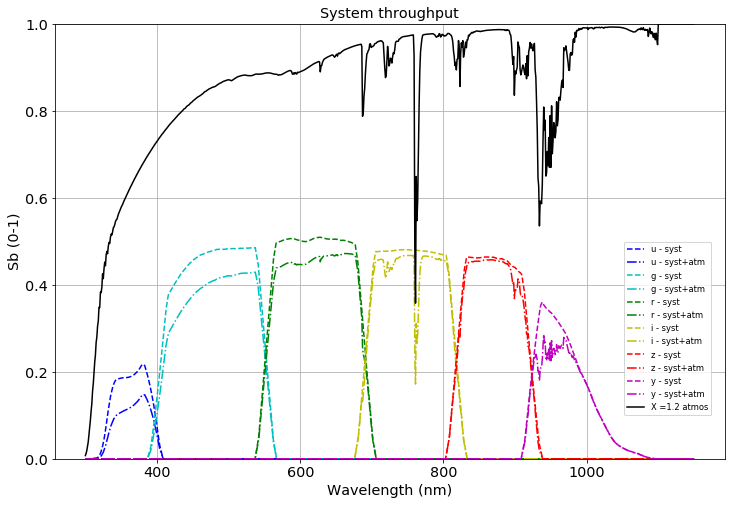

In [44]:
tel_mt.Set_Atmosphere(am,wl,tr)
tel_mt.Plot_Throughputs()

## Tune pwv

In [45]:
all_pwv=np.arange(0.,10.,0.5)

In [46]:
NBRTFILES=len(all_pwv)

In [47]:
NBSED_SEL=5000

# Simulate LibRadTran

In [48]:

pressure = 782.5
pwv=4.0
aer=0
ozone=300.
wl0=500.

In [49]:
all_rtdata=[]
for pwv in all_pwv:
    path,thefile=rt.ProcessSimulationaer(am,pwv,ozone,wl0,aer)
    #path,thefile=rt.ProcessSimulation(am,pwv,ozone)
    data = np.loadtxt(os.path.join(path,thefile))
    all_rtdata.append(data)

--------------------------------------------
 1) airmass =  1.2
 2) pwv =  0.0
 3) oz =  300.0
 4) wl0 =  500.0
 5) tau0 =  0
--------------------------------------------
Running uvspec with input file:  /scratch/dagoret/simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z12_wv0_oz30_aer0.INP
Output to file                :  /scratch/dagoret/simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv0_oz30_aer0.OUT
uvspec cmd:  /pbs/throng/lsst/users/dagoret/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < /scratch/dagoret/simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z12_wv0_oz30_aer0.INP > /scratch/dagoret/simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv0_oz30_aer0.OUT
--------------------------------------------
 1) airmass =  1.2
 2) pwv =  0.5
 3) oz =  300.0
 4) wl0 =  500.0
 5) tau0 =  0
--------------------------------------------
Running uvspec with input file:  /scratch/dagoret/simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z1

In [50]:
jet = cm = plt.get_cmap('jet')
cNorm  = colors.Normalize(vmin=0, vmax=NBRTFILES)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

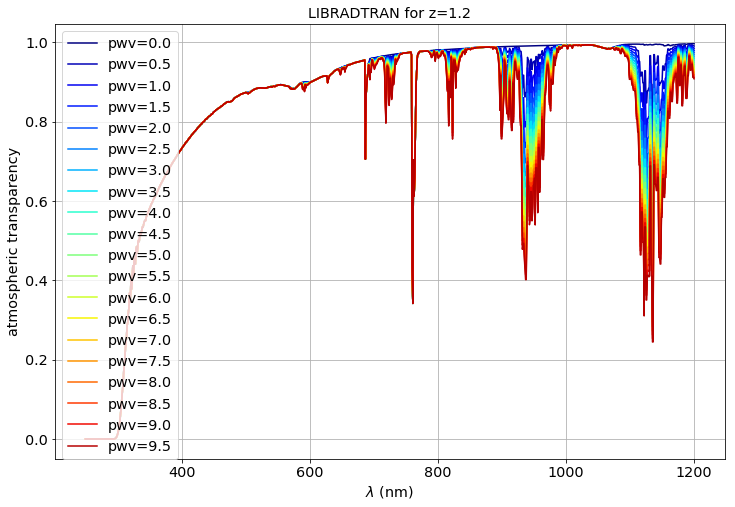

In [51]:
for idx in np.arange(NBRTFILES):    
    colorVal = scalarMap.to_rgba(idx)
    thelabel="pwv={:2.1f}".format(all_pwv[idx])
    plt.plot(all_rtdata[idx][:,0],all_rtdata[idx][:,1],color=colorVal,label=thelabel)
plt.grid(True)
plt.title("LIBRADTRAN for z={:2.1f}".format(am))
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("atmospheric transparency")
plt.legend(loc='upper left')

In [52]:
all_pwv

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5])

# LibRadTran Telescope

In [53]:
idx_pwv_sel=10

In [54]:
all_pwv[idx_pwv_sel]

5.0

In [55]:
rtdata_sel=all_rtdata[idx_pwv_sel]

In [56]:
tel_rt=Telescope()

**** Throughputs.__init__****
System loaded from /sps/lsst/software/lsst_sims/sims_2_7_0/stack/miniconda3-4.3.21-10a4fa6/Linux64/throughputs/2017.01.31-6-g29ce4f5/baseline/
**** Telescope.__init__******


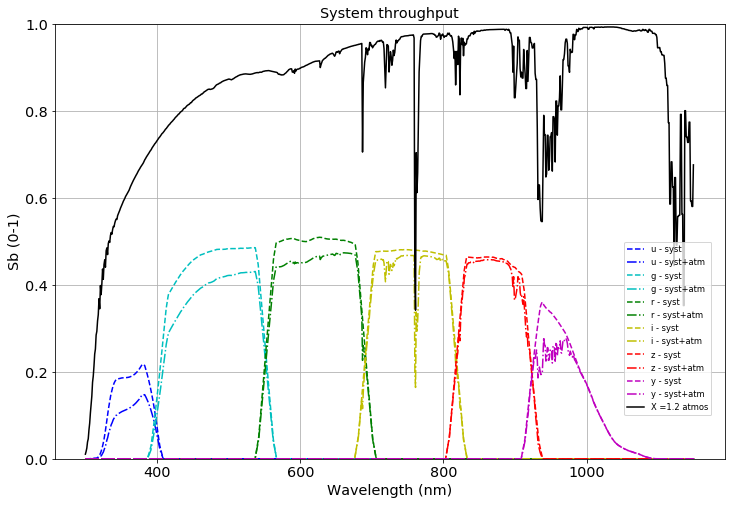

In [57]:
tel_rt.Set_Atmosphere(am,rtdata_sel[:,0],rtdata_sel[:,1])
tel_rt.Plot_Throughputs()

# LOOP on SED

In [58]:

filter_tag='y'


In [59]:
def ComputeDeltaMagAndErrorMag(filter_tag,tel_rt,tel_mt,sed_data):
    
    
    filternum=all_filternum[filter_tag]-1
    skybrightness=LSST_SkyBrightness[filternum]
    FWHMgeom=LSST_GeomSeeing[filternum]
    
    
    # book collections
    all_pulls=np.zeros(NBSED_SEL)
    all_magdelta=np.zeros(NBSED_SEL)
    all_magerr=np.zeros(NBSED_SEL)

    #print("NBSED_SEL={}".format(NBSED_SEL))
    
    #loop on SED
    for idx_sed in np.arange(NBSED_SEL):
        # extract sed wl and flux
        picklesname='pickles_uvk_{}'.format(idx_sed+1)
        wl_sed=sed_data[0,sidx_spec:]/10.
        flux_sed=sed_data[idx_sed+1,sidx_spec:]*10.
        
        # fill Telescope with that SED
        tel_rt.Set_SED(wavel=wl_sed,newsed=flux_sed,name=picklesname)
        tel_mt.Set_SED(wavel=wl_sed,newsed=flux_sed,name=picklesname)
        
        #compute Instrumental Magnitude
        mag_adu_mt=tel_mt.CalcMyADUMagnitude_filter(filter_tag)
        mag_adu_rt=tel_rt.CalcMyADUMagnitude_filter(filter_tag)
        
        # compute magnitude error and delta mag
        mag_error=tel_rt.CalcMyABMagnitudesError_filter(filter_tag,skybrightness,FWHMgeom)
        delta_mag= mag_adu_mt-mag_adu_rt
    
        #print('\Delta M = {} \delta m = {} '.format(delta_mag,mag_error))
        
        #fill collection
        all_pulls[idx_sed]=delta_mag/mag_error
        all_magdelta[idx_sed]=delta_mag
        all_magerr[idx_sed]=mag_error
        
        
        #plt.semilogy(wl_sed,flux_sed)

    return all_magdelta,all_magerr,all_pulls
        

In [60]:
def ComputeChi2(all_pulls):
    all_pulls2=all_pulls**2
    N=len(all_pulls)
    chi2=all_pulls2.sum()/(float(N-1))
    return chi2

In [61]:
all_magdelta,all_magerr,all_pulls=ComputeDeltaMagAndErrorMag(filter_tag,tel_rt,tel_mt,sed_data)

In [62]:
ComputeChi2(all_pulls)

0.0065955296816798074

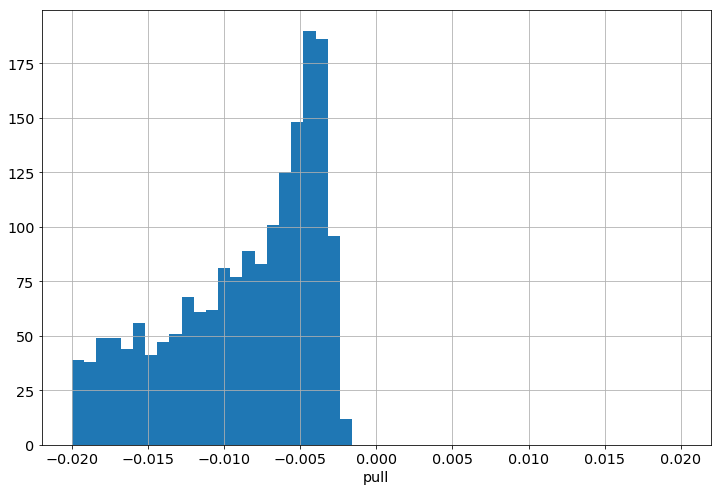

In [63]:
plt.hist(all_pulls,bins=50,range=(-0.02,0.02));
plt.grid()
plt.xlabel("pull")

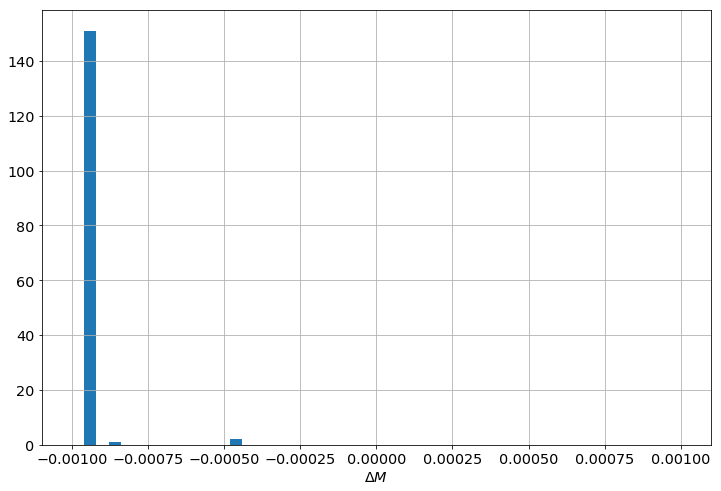

In [64]:
plt.hist(all_magdelta,bins=50,range=(-0.001,0.001));
plt.grid()
plt.xlabel("$\Delta M$")

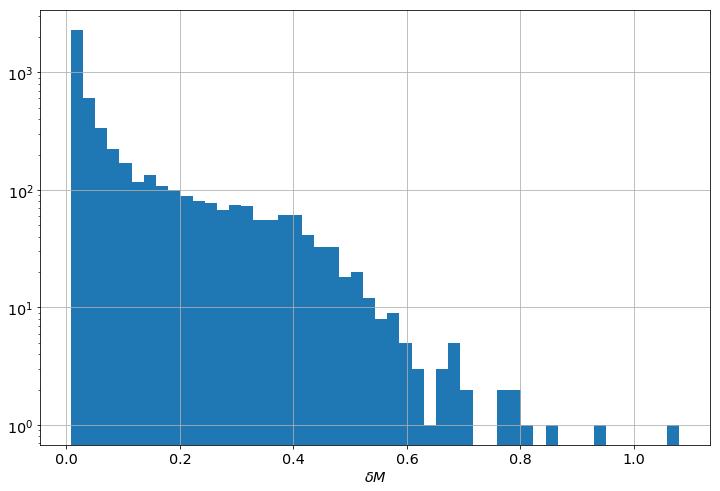

In [65]:
plt.hist(all_magerr,bins=50);
plt.grid()
plt.xlabel("$\delta M$")
plt.yscale('log')

# LOOP ON PWV

In [66]:
jet = cm = plt.get_cmap('jet')
cNorm  = colors.Normalize(vmin=all_pwv.min(), vmax=all_pwv.max())
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colorvalues    = [scalarMap.to_rgba(pwv) for pwv in all_pwv]
scalarMap.set_array(all_colorvalues)

index_pwv=0 , pwv=0.0
index_pwv=1 , pwv=0.5
index_pwv=2 , pwv=1.0
index_pwv=3 , pwv=1.5
index_pwv=4 , pwv=2.0
index_pwv=5 , pwv=2.5
index_pwv=6 , pwv=3.0
index_pwv=7 , pwv=3.5
index_pwv=8 , pwv=4.0
index_pwv=9 , pwv=4.5
index_pwv=10 , pwv=5.0
index_pwv=11 , pwv=5.5
index_pwv=12 , pwv=6.0
index_pwv=13 , pwv=6.5
index_pwv=14 , pwv=7.0
index_pwv=15 , pwv=7.5
index_pwv=16 , pwv=8.0
index_pwv=17 , pwv=8.5
index_pwv=18 , pwv=9.0
index_pwv=19 , pwv=9.5


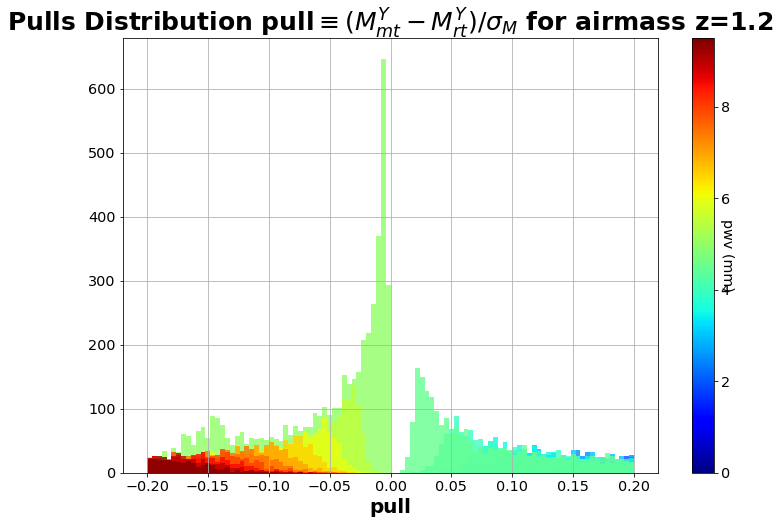

In [67]:
all_chi2=[]

plt.figure()
for idx,pwv in np.ndenumerate(all_pwv):
    print("index_pwv={} , pwv={}".format(idx[0],pwv))
    
    
    # select atmosphere for libradtran
    idx_pwv_sel=idx[0]
    rtdata_sel=all_rtdata[idx_pwv_sel]
    tel_rt.Set_Atmosphere(am,rtdata_sel[:,0],rtdata_sel[:,1])
    all_magdelta,all_magerr,all_pulls=ComputeDeltaMagAndErrorMag(filter_tag,tel_rt,tel_mt,sed_data)
    all_chi2.append(ComputeChi2(all_pulls))
    
    
    colorVal = scalarMap.to_rgba(pwv)
    thelabel="pwv={:2.1f} mm".format(pwv)
    
    plt.hist(all_pulls,bins=100,range=(-0.2,0.2),color=colorVal,alpha=0.8);
    
cbar=plt.colorbar(scalarMap)
cbar.set_label('pwv (mm)', rotation=270)    
    
plt.grid(True)
plt.xlabel("pull",fontweight='bold',fontsize=20)
title="Pulls Distribution pull$\equiv(M_{mt}^Y-M_{rt}^Y)/\sigma_M$"
title=title+" for airmass z={}".format(am)
plt.title(title,fontweight='bold',fontsize=25)
#plt.legend(loc='best')

# Estimation of PWV in libradtran

In [68]:
x=np.array(all_pwv)
y=np.array(all_chi2)
z = np.polyfit(x, y, 4)
parab= np.poly1d(z)
newx=np.linspace(x[0],x[-1],50)
newy=parab(newx)

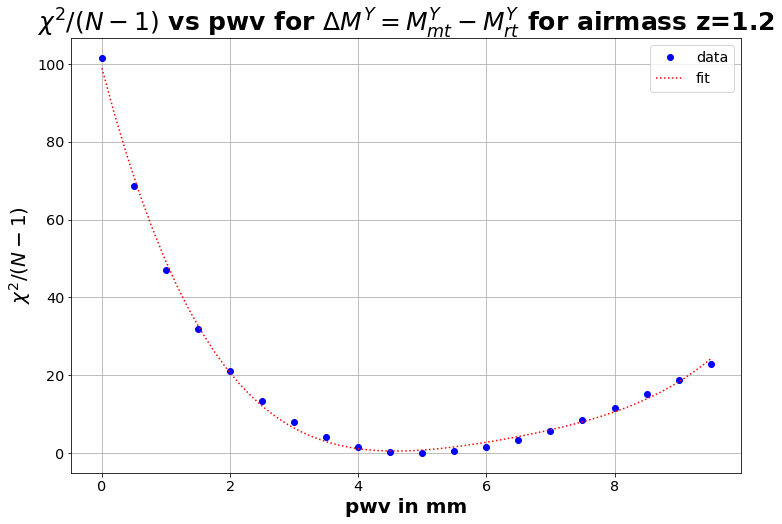

In [69]:
title="$\chi^2/(N-1)$ vs pwv for $\Delta M^Y=M_{mt}^Y-M_{rt}^Y$"
title=title+" for airmass z={}".format(am)
plt.plot(all_pwv,all_chi2,'bo',label='data')
plt.plot(newx,newy,'r:',label='fit')
plt.ylabel("$\chi^2/(N-1)$",fontweight='bold',fontsize=20)
plt.xlabel("pwv in mm",fontweight='bold',fontsize=20)
plt.grid(True)
plt.title(title,fontweight='bold',fontsize=25)
plt.legend(loc="upper right")

In [70]:
z

array([  5.89146275e-02,  -1.49128853e+00,   1.46499300e+01,
        -6.29643277e+01,   9.89306516e+01])

In [71]:
def FindOptimum(X,Y):
    idx0=np.where(Y==Y.min())[0][0]
    print("minimum is at X={}, Y={}".format(X[idx0],Y[idx0]))
    
    close_idx=np.where(Y<=Y.min()+1)[0]
    #for idx2 in close_idx:
    #      print("neighbourg {} : is at X={}, Y={}".format(idx2,X[idx2],Y[idx2]))
            
    print("X1 = {} - X2 = {}".format(X[close_idx[0]], X[close_idx[-1]]))
    sigma=0.5*( (X[idx0]-X[close_idx[0]])+(X[close_idx[-1]]-X[idx0]))
    print("Sigma= {}".format(sigma))
    return X[idx0],sigma

In [72]:
pwv0,sigpwv=FindOptimum(newx,newy)

minimum is at X=4.653061224489796, Y=0.518840061423731
X1 = 3.877551020408163 - X2 = 5.428571428571429
Sigma= 0.7755102040816328


In [73]:
pwv0=5.0

# Find Magnitude difference

In [74]:
path,thefile=rt.ProcessSimulationaer(am,pwv0,ozone,wl0,aer)
#path,thefile=rt.ProcessSimulation(am,pwv,ozone)
rtdata0 = np.loadtxt(os.path.join(path,thefile))

--------------------------------------------
 1) airmass =  1.2
 2) pwv =  5.0
 3) oz =  300.0
 4) wl0 =  500.0
 5) tau0 =  0
--------------------------------------------
Running uvspec with input file:  /scratch/dagoret/simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z12_wv50_oz30_aer0.INP
Output to file                :  /scratch/dagoret/simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv50_oz30_aer0.OUT
uvspec cmd:  /pbs/throng/lsst/users/dagoret/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < /scratch/dagoret/simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z12_wv50_oz30_aer0.INP > /scratch/dagoret/simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv50_oz30_aer0.OUT


In [75]:
tel_rt.Set_Atmosphere(am,rtdata0[:,0],rtdata0[:,1])

In [76]:
#tel_rt.Plot_Throughputs()

In [77]:
all_magdelta0,all_magerr0,all_pulls0=ComputeDeltaMagAndErrorMag(filter_tag,tel_rt,tel_mt,sed_data)

In [78]:
mag_mean=all_magdelta0.mean()
mag_std=all_magdelta0.std()

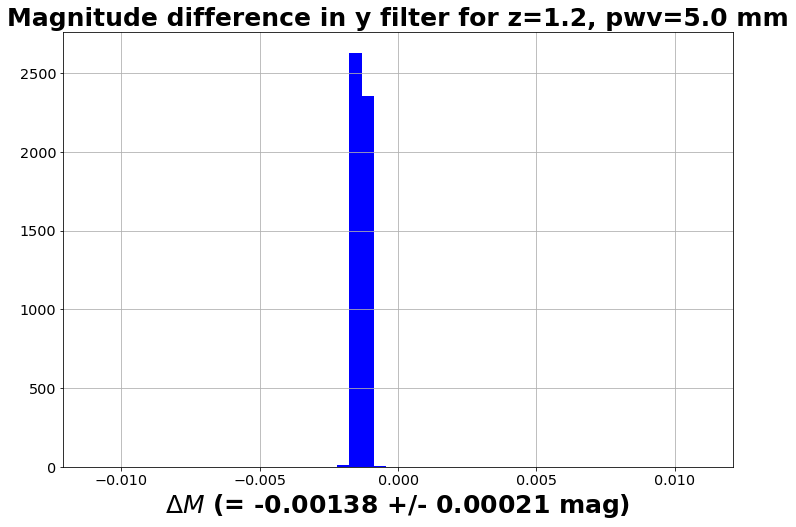

In [79]:
plt.hist(all_magdelta0,bins=50,range=(-0.011,0.011),color="blue");
plt.grid()

xlabel="$\Delta M$ (= {:6.5f} +/- {:6.5f} mag)".format(mag_mean,mag_std)
plt.xlabel(xlabel,fontweight='bold',fontsize=25)
title="Magnitude difference in {} filter for z={}, pwv={} mm".format(filter_tag,am,pwv0)
plt.title(title,fontweight='bold',fontsize=25)

In [80]:
filter_tag='z'

In [81]:
all_magdelta0,all_magerr0,all_pulls0=ComputeDeltaMagAndErrorMag(filter_tag,tel_rt,tel_mt,sed_data)

In [82]:
mag_mean=all_magdelta0.mean()
mag_std=all_magdelta0.std()

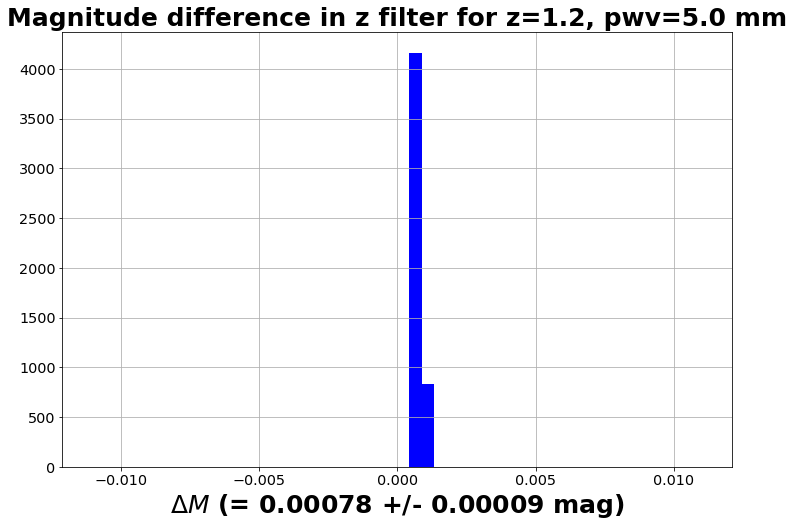

In [83]:
plt.hist(all_magdelta0,bins=50,range=(-0.011,0.011),color="blue");
plt.grid()

xlabel="$\Delta M$ (= {:6.5f} +/- {:6.5f} mag)".format(mag_mean,mag_std)
plt.xlabel(xlabel,fontweight='bold',fontsize=25)
title="Magnitude difference in {} filter for z={}, pwv={} mm".format(filter_tag,am,pwv0)
plt.title(title,fontweight='bold',fontsize=25)

In [84]:
filter_tag='i'

In [85]:
all_magdelta0,all_magerr0,all_pulls0=ComputeDeltaMagAndErrorMag(filter_tag,tel_rt,tel_mt,sed_data)

In [86]:
mag_mean=all_magdelta0.mean()
mag_std=all_magdelta0.std()

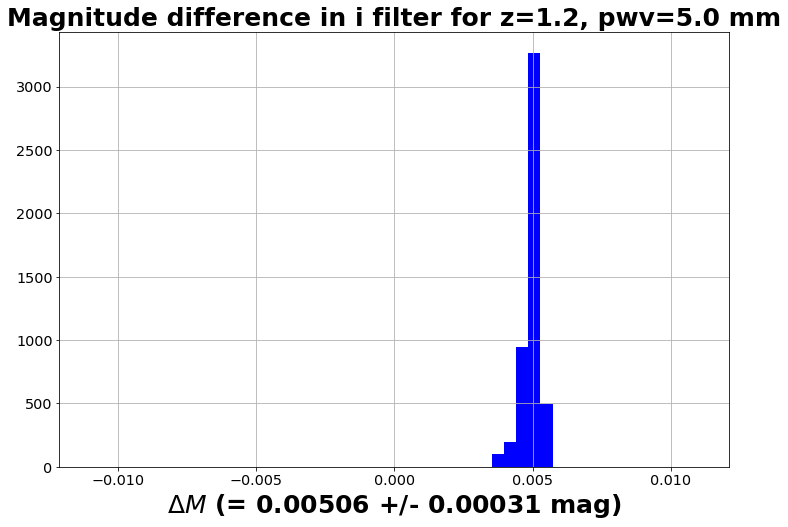

In [87]:
plt.hist(all_magdelta0,bins=50,range=(-0.011,0.011),color="blue");
plt.grid()

xlabel="$\Delta M$ (= {:6.5f} +/- {:6.5f} mag)".format(mag_mean,mag_std)
plt.xlabel(xlabel,fontweight='bold',fontsize=25)
title="Magnitude difference in {} filter for z={}, pwv={} mm".format(filter_tag,am,pwv0)
plt.title(title,fontweight='bold',fontsize=25)

In [88]:
filter_tag='r'

In [89]:
all_magdelta0,all_magerr0,all_pulls0=ComputeDeltaMagAndErrorMag(filter_tag,tel_rt,tel_mt,sed_data)

In [90]:
mag_mean=all_magdelta0.mean()
mag_std=all_magdelta0.std()

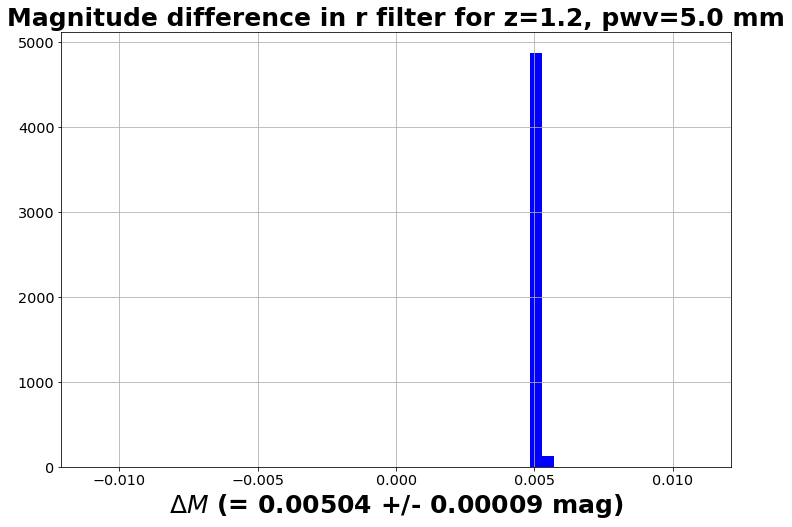

In [91]:
plt.hist(all_magdelta0,bins=50,range=(-0.011,0.011),color="blue");
plt.grid()

xlabel="$\Delta M$ (= {:6.5f} +/- {:6.5f} mag)".format(mag_mean,mag_std)
plt.xlabel(xlabel,fontweight='bold',fontsize=25)
title="Magnitude difference in {} filter for z={}, pwv={} mm".format(filter_tag,am,pwv0)
plt.title(title,fontweight='bold',fontsize=25)